### SageMaker Stable diffusion Quick Kit - Inference 部署(ControlNet)
   [SageMaker Stable Diffusion Quick Kit](https://github.com/aws-samples/sagemaker-stablediffusion-quick-kit) 提供了一组开箱即用的代码、配置文件，它可以帮助客户在亚马逊云上使用Amazon SageMaker , Lambda, Cloudfront快速构建Stable diffusion AI绘图服务.
   
   ![架构](https://raw.githubusercontent.com/aws-samples/sagemaker-stablediffusion-quick-kit/main/images/architecture.png)


#### 前提条件
1. 亚马逊云账号
2. 建议使用ml.g4dn.xlarge/ml.g5.xlarge

### Notebook部署步骤
1. 升级boto3, sagemaker python sdk
2. 编译docker image
3. 部署AIGC推理服务
    * 配置模型参数
    * 配置异步推理
    * 部署SageMaker Endpoint 
4. 测试ControlNet模型
5. 清除资源


### 1. 升级boto3, sagemaker python sdk

In [ ]:
!pip install --upgrade boto3 sagemaker

In [ ]:
#导入对应的库

import re
import os
import json
import uuid

import numpy as np
import pandas as pd
from time import gmtime, strftime


import boto3
import sagemaker

from sagemaker import get_execution_role,session

role = get_execution_role()


sage_session = session.Session()
bucket = sage_session.default_bucket()
aws_region = boto3.Session().region_name


print(f'sagemaker sdk version: {sagemaker.__version__}\nrole:  {role}  \nbucket:  {bucket}')




### 2. 编译docker image

In [ ]:
!./build_push.sh

### 3. 部署AIGC推理服务

#### 3.1 创建dummy model_data 文件(真正的模型使用code/infernece.py进行加载)

In [79]:
!touch dummy
!tar czvf model.tar.gz dummy sagemaker-logo-small.png
assets_dir = 's3://{0}/{1}/assets/'.format(bucket, 'stablediffusion')
model_data = 's3://{0}/{1}/assets/model.tar.gz'.format(bucket, 'stablediffusion')
!aws s3 cp model.tar.gz $assets_dir
!rm -f dummy model.tar.gz

dummy
sagemaker-logo-small.png
upload: ./model.tar.gz to s3://sagemaker-us-east-1-596030579944/stablediffusion/assets/model.tar.gz


#### 3.2 创建 model 配置

In [80]:

boto3_session = boto3.session.Session()
current_region=boto3_session.region_name

client = boto3.client("sts")
account_id=client.get_caller_identity()["Account"]

client = boto3.client('sagemaker')

#使用步骤2编译好的docker images
container = f'{account_id}.dkr.ecr.{current_region}.amazonaws.com/sd-inference-v2'

model_data = f's3://{bucket}/stablediffusion/assets/model.tar.gz'


model_name = 'AIGC-Quick-Kit-' +  strftime("%Y-%m-%d-%H-%M-%S", gmtime())
role = get_execution_role()

primary_container = {
    'Image': container,
    'ModelDataUrl': model_data,
    'Environment':{
        's3_bucket': bucket,
        'model_name':'runwayml/stable-diffusion-v1-5' #默认为runwayml/stable-diffusion-v1-5
    }
}

create_model_response = client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container,


)

In [81]:
_time_tag = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
_variant_name =  'AIGC-Quick-Kit-'+ _time_tag
endpoint_config_name = 'AIGC-Quick-Kit-' +  _time_tag

response = client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            'VariantName': _variant_name,
            'ModelName': model_name,
            'InitialInstanceCount': 1,
            'InstanceType': 'ml.g4dn.2xlarge',
            'InitialVariantWeight': 1
        },
    ]
    ,
    AsyncInferenceConfig={
        'OutputConfig': {
            'S3OutputPath': f's3://{bucket}/stablediffusion/asyncinvoke/out/'
        }
    }
)

#### 3.3 部署SageMaker endpoint

In [82]:
endpoint_name = f'AIGC-Quick-Kit-{str(uuid.uuid4())}'


response = client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name,
    
)



print(f'终端节点:{endpoint_name} 正在创建中，首次启动中会加载模型，请耐心等待, 请在控制台上查看状态')


终端节点:AIGC-Quick-Kit-8a753c53-04c0-488b-8ead-b5e01b168db6 正在创建中，请在控制台上查看状态


### 4. ControlNet 测试

### 4.1 辅助方法 

In [91]:
import time
import uuid
import io
import traceback
from PIL import Image


s3_resource = boto3.resource('s3')

def get_bucket_and_key(s3uri):
    pos = s3uri.find('/', 5)
    bucket = s3uri[5 : pos]
    key = s3uri[pos + 1 : ]
    return bucket, key


def predict_async(endpoint_name,payload):
    runtime_client = boto3.client('runtime.sagemaker')
    input_file=str(uuid.uuid4())+".json"
    s3_resource = boto3.resource('s3')
    s3_object = s3_resource.Object(bucket, f'stablediffusion/asyncinvoke/input/{input_file}')
    payload_data = json.dumps(payload).encode('utf-8')
    s3_object.put( Body=bytes(payload_data))
    input_location=f's3://{bucket}/stablediffusion/asyncinvoke/input/{input_file}'
    print(f'input_location: {input_location}')
    response = runtime_client.invoke_endpoint_async(
        EndpointName=endpoint_name,
        InputLocation=input_location
    )
    result =response.get("OutputLocation",'')
    wait_async_result(result)


def s3_object_exists(s3_path):
    """
    s3_object_exists
    """
    try:
        s3 = boto3.client('s3')
        base_name=os.path.basename(s3_path)
        _,ext_name=os.path.splitext(base_name)
        bucket,key=get_bucket_and_key(s3_path)
        
        s3.head_object(Bucket=bucket, Key=key)
        return True
    except Exception as ex:
        print("job is not completed, waiting...")   
        return False
    
def draw_image(output_location):
    try:
        bucket, key = get_bucket_and_key(output_location)
        obj = s3_resource.Object(bucket, key)
        body = obj.get()['Body'].read().decode('utf-8') 
        predictions = json.loads(body)
        print(predictions['result'])
        for image in predictions['result']:
            bucket, key = get_bucket_and_key(image)
            obj = s3_resource.Object(bucket, key)
            bytes = obj.get()['Body'].read()
            image = Image.open(io.BytesIO(bytes))
            #resize image to 50% size
            half = 0.5
            out_image = image.resize( [int(half * s) for s in image.size] )
            out_image.show()
    except Exception as e:
        print("result is not completed, waiting...")   
    

    
def wait_async_result(output_location,timeout=60):
    current_time=0
    while current_time<timeout:
        if s3_object_exists(output_location):
            print("have async result")
            draw_image(output_location)
            break
        else:
            time.sleep(5)

            
def check_sendpoint_status(endpoint_name):
    client = boto3.client('sagemaker')
    response = client.describe_endpoint(
        EndpointName=endpoint_name
    )
    if response['EndpointStatus'] !='InService':
        raise Exception (f'{endpoint_name} not ready , please wait....')
    else:
        status = response['EndpointStatus']
        print(f'{endpoint_name} is ready, status: {status}')

#### 检查endpoint 状态

In [92]:
check_sendpoint_status(endpoint_name)

AIGC-Quick-Kit-8a753c53-04c0-488b-8ead-b5e01b168db6 is ready, status: InService


### 4.1 Canny 测试



input_location: s3://sagemaker-us-east-1-596030579944/stablediffusion/asyncinvoke/input/04013304-982e-49b3-8247-205f5ead464e.json
job is not completed, waiting...
job is not completed, waiting...
job is not completed, waiting...
have async result
['s3://sagemaker-us-east-1-596030579944/stablediffusion/asyncinvoke/images/0460e673-8077-4b78-85bb-42c6c4113eef.jpg', 's3://sagemaker-us-east-1-596030579944/stablediffusion/asyncinvoke/images/21f8bce0-6783-4fd5-84ec-b2effcfd1ea1.jpg', 's3://sagemaker-us-east-1-596030579944/stablediffusion/asyncinvoke/images/346ae1b8-9ecf-4415-95f2-ffa7acfe82d5.jpg']


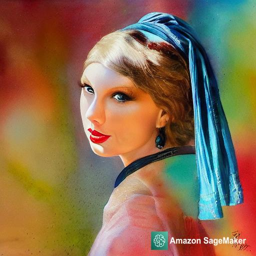

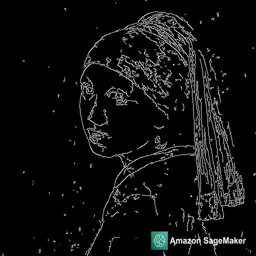

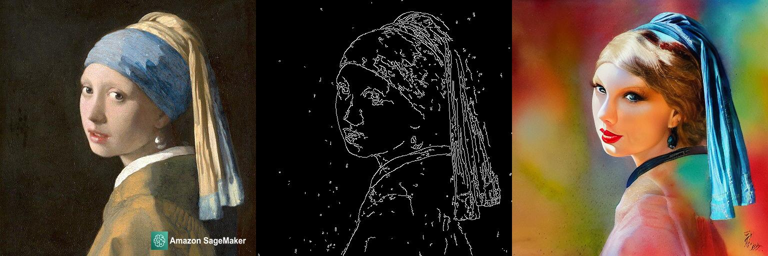

In [93]:

payload={
                "prompt": "taylor swift, best quality, extremely detailed",
                "negative_prompt":"monochrome, lowres, bad anatomy, worst quality, low quality",
                "steps":20,
                "sampler":"euler_a",
                "seed":43768,
                "height": 512, 
                "width": 512,
                "count":2,
                "control_net_model":"canny",
                "input_image":"https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
}

predict_async(endpoint_name,payload)


### 4.2 Openpose 测试

input_location: s3://sagemaker-us-east-1-596030579944/stablediffusion/asyncinvoke/input/044daeab-8fd6-4f5d-bcd6-f897f55bc73b.json
job is not completed, waiting...
job is not completed, waiting...
job is not completed, waiting...
job is not completed, waiting...
have async result
['s3://sagemaker-us-east-1-596030579944/stablediffusion/asyncinvoke/images/a6defa46-c955-4a87-94a1-84b31457f8c4.jpg', 's3://sagemaker-us-east-1-596030579944/stablediffusion/asyncinvoke/images/7ea314ee-1a91-499c-ab47-a3f350f9910e.jpg', 's3://sagemaker-us-east-1-596030579944/stablediffusion/asyncinvoke/images/89ce24a4-f8da-442b-9256-b7b0689f03ae.jpg']


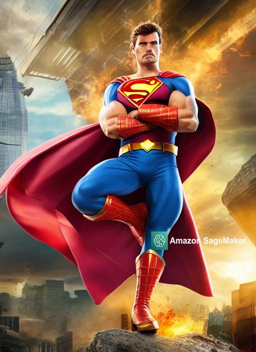

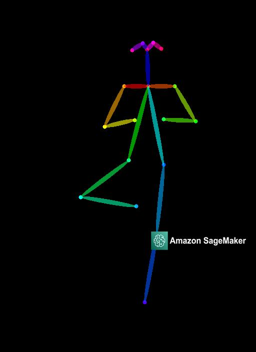

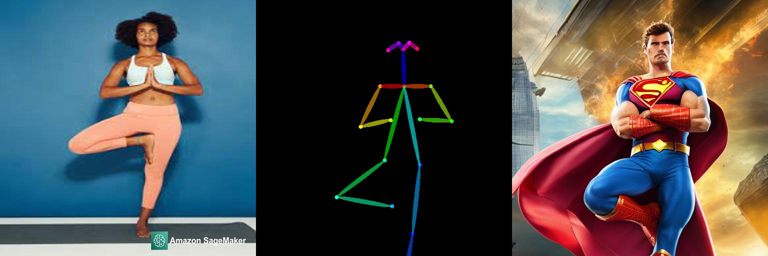

In [94]:
payload={
                    "prompt": "super-hero character, best quality, extremely detailed",
                    "negative_prompt":"monochrome, lowres, bad anatomy, worst quality, low quality",
                    "steps":20,
                    "sampler":"euler_a",
                    "seed":43768,
                    "height": 512,
                    "width": 512,
                    "count":2,
                    "control_net_model":"openpose",
                    "input_image":"https://huggingface.co/datasets/YiYiXu/controlnet-testing/resolve/main/yoga1.jpeg"
}
predict_async(endpoint_name,payload)

### 4.3 mlsd 测试

input_location: s3://sagemaker-us-east-1-596030579944/stablediffusion/asyncinvoke/input/a29b776e-49ab-46d3-bdcc-7aa301a64f60.json
job is not completed, waiting...
job is not completed, waiting...
job is not completed, waiting...
have async result
['s3://sagemaker-us-east-1-596030579944/stablediffusion/asyncinvoke/images/d036d4fc-2ba0-4ef4-a6d2-bbb200bb3f93.jpg', 's3://sagemaker-us-east-1-596030579944/stablediffusion/asyncinvoke/images/fc1bd95c-00b7-4eba-ad45-a0bc0d38858e.jpg', 's3://sagemaker-us-east-1-596030579944/stablediffusion/asyncinvoke/images/c6ba2da0-7957-4d03-989a-c94d8c63a8d5.jpg']


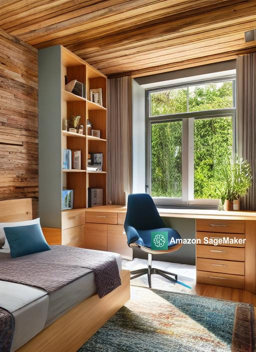

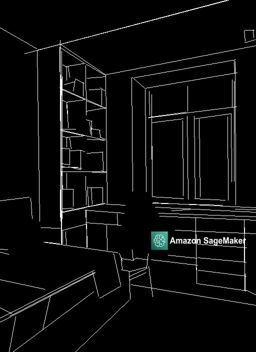

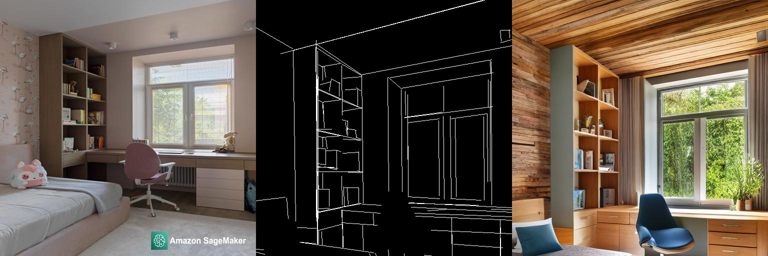

In [95]:
payload={
                    "prompt": "room",
                    "negative_prompt":"monochrome, lowres, bad anatomy, worst quality, low quality",
                    "steps":20,
                    "sampler":"euler_a",
                    "seed":43768,
                    "height": 512,
                    "width": 512,
                    "count":2,
                    "control_net_model":"mlsd",
                    "input_image":"https://huggingface.co/lllyasviel/sd-controlnet-mlsd/resolve/main/images/room.png"
}
predict_async(endpoint_name,payload)

### 4.4 depth 测试

input_location: s3://sagemaker-us-east-1-596030579944/stablediffusion/asyncinvoke/input/3eee83ef-e9d4-42ce-b6e5-541799fa7ece.json
job is not completed, waiting...
job is not completed, waiting...
job is not completed, waiting...
have async result
['s3://sagemaker-us-east-1-596030579944/stablediffusion/asyncinvoke/images/abb4745e-2c95-4638-b1c5-ede95b710bc2.jpg', 's3://sagemaker-us-east-1-596030579944/stablediffusion/asyncinvoke/images/bf0e84c1-73c9-4377-b405-8e653d4379bb.jpg', 's3://sagemaker-us-east-1-596030579944/stablediffusion/asyncinvoke/images/97b8237d-5685-4cd3-b9e4-1c9bf7d4d81f.jpg']


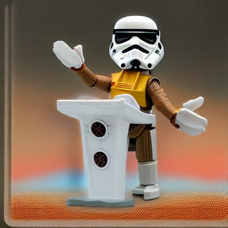

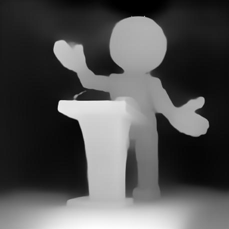

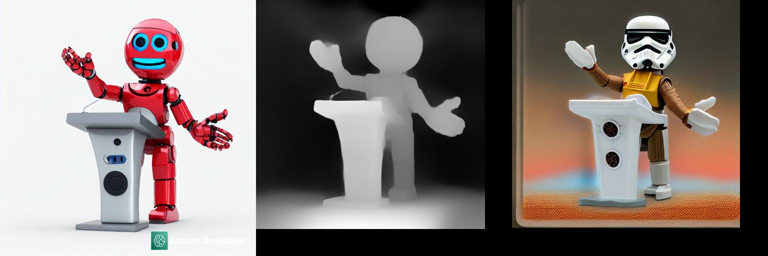

In [96]:
payload={
                    "prompt": "Stormtrooper's lecture",
                    "negative_prompt":"monochrome, lowres, bad anatomy, worst quality, low quality",
                    "steps":20,
                    "sampler":"euler_a",
                    "seed":43768,
                    "height": 512,
                    "width": 512,
                    "count":2,
                    "control_net_model":"depth",
                    "input_image":"https://huggingface.co/lllyasviel/sd-controlnet-depth/resolve/main/images/stormtrooper.png"
                }
predict_async(endpoint_name,payload)

### 4.5 hed 测试

input_location: s3://sagemaker-us-east-1-596030579944/stablediffusion/asyncinvoke/input/ab9c6173-ddab-4f8c-81bf-5efea2770a4d.json
job is not completed, waiting...
job is not completed, waiting...
job is not completed, waiting...
have async result
['s3://sagemaker-us-east-1-596030579944/stablediffusion/asyncinvoke/images/8bf54ec7-4a7a-49b0-b69d-767aa255238d.jpg', 's3://sagemaker-us-east-1-596030579944/stablediffusion/asyncinvoke/images/a46554e2-2bcd-4421-954e-05bbb422dd0e.jpg', 's3://sagemaker-us-east-1-596030579944/stablediffusion/asyncinvoke/images/e3d15c2f-f8ae-4dfa-8487-e493196e64e8.jpg']


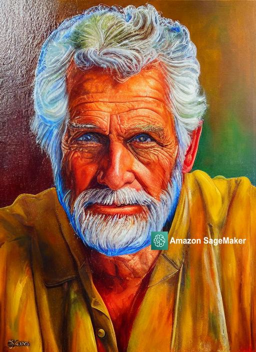

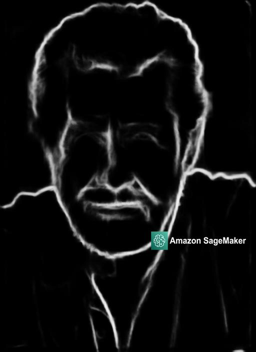

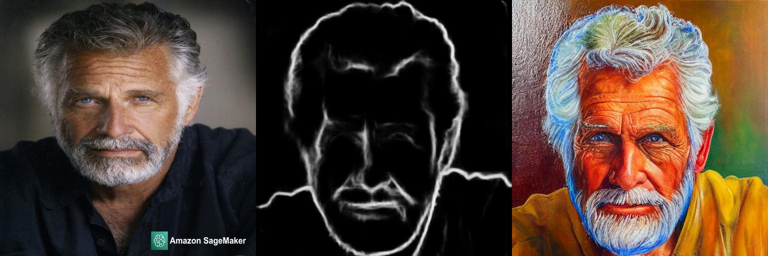

In [97]:
 payload={
                    "prompt": "oil painting of handsome old man, masterpiece",
                    "negative_prompt":"monochrome, lowres, bad anatomy, worst quality, low quality",
                    "steps":20,
                    "sampler":"euler_a",
                    "seed":43768,
                    "height": 512,
                    "width": 512,
                    "count":2,
                    "control_net_model":"hed",
                    "input_image":"https://huggingface.co/lllyasviel/sd-controlnet-hed/resolve/main/images/man.png"
                }
predict_async(endpoint_name,payload)

### 4.6 scribble 测试

input_location: s3://sagemaker-us-east-1-596030579944/stablediffusion/asyncinvoke/input/c054718a-ad5a-4207-823d-2b10ec1517ef.json
job is not completed, waiting...
job is not completed, waiting...
job is not completed, waiting...
have async result
['s3://sagemaker-us-east-1-596030579944/stablediffusion/asyncinvoke/images/8f299444-387f-4005-a7e9-edf88386295c.jpg', 's3://sagemaker-us-east-1-596030579944/stablediffusion/asyncinvoke/images/72d14ae3-b303-499a-94a9-544ba4aa4cef.jpg', 's3://sagemaker-us-east-1-596030579944/stablediffusion/asyncinvoke/images/13ec3b3f-9453-4ddf-ba6c-1f4086afb707.jpg']


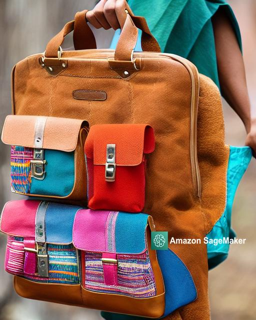

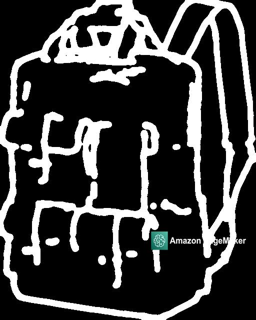

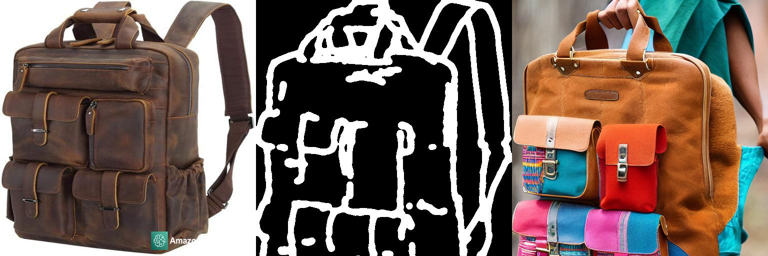

In [98]:
payload={
                    "prompt": "bag",
                    "negative_prompt":"monochrome, lowres, bad anatomy, worst quality, low quality",
                    "steps":20,
                    "sampler":"euler_a",
                    "seed":43768,
                    "height": 512,
                    "width": 512,
                    "count":2,
                    "control_net_model":"scribble",
                    "input_image":"https://huggingface.co/lllyasviel/sd-controlnet-scribble/resolve/main/images/bag.png"
          }
predict_async(endpoint_name,payload)

### 5 清除资源

In [ ]:
response = client.delete_endpoint(
    EndpointName=endpoint_name
    
)

response = client.delete_endpoint_config(
    EndpointConfigName=endpoint_config_name
)


print(f'终端节点:{endpoint_name} 已经被清除，请在控制台上查看状态')
